In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
########################################
### READ TREES AND CREATE DATAFRAMES ###
########################################


# fix random seed for reproducibility
np.random.seed(1986)

features = [
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    'mu_charge' ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    'mu1_charge',
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
    'mu2_charge',
]

#create DataFrames with the values coming from the trees
file_tau = uproot.open('bc_jpsi_tau_nu_gen.root')
tree_tau = file_tau['tree;1']
tau  = tree_tau.pandas.df(tree_tau.keys())

file_mu = uproot.open('bc_jpsi_mu_nu_gen.root')
tree_mu = file_mu['tree;1']
mu  = tree_mu.pandas.df(tree_mu.keys())

In [3]:
#########################################
### PREPARE DFs FOR TRAINING AND TEST ###
#########################################


#add the column target to both dataframes
mu ['target'] = 0
tau['target'] = 1

# concatenate the two samples
dataset = pd.concat([mu, tau])

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])

In [4]:
########################
### DEFINE THE MODEL ###
########################

# define the model
model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


**Sequential()**: 

    essentially stack one after the other the layers of the NN

**Dense()**:

    creates the single layer of the NN
    Dense(int=output_array_shape [(*,int)],imput_dim [(*,input_dim)],activation_fct)

An **activation function**: 

    It is a transfer function that is used to map the output of one layer to another
    e.g. 
        relu:
        A straight line function where activation is proportional to input (which is the weighted sum from neuron)

An **error function** must be chosen in order to estimate if I am doing things right or wrong: for NN the error function is called **loss function**. It is used to modify the weights in order to improve the result at the following iteration of the net

The **cross entropy** between two probability distributions p and q over the same underlying set of events measures the average number of bits needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution q, rather than the true distribution p. **It's the default choice for binary problems**

**adam** (**ada**ptive **m**oment estimation) is an optimization algorithm. When compiling a NN you must choose what type of optimization algorith you NN should follow

**metric function** is similar to a loss function, except that the results from evaluating a metric are not used when training the model. You may use any of the loss functions as a metric function.

In [5]:
#######################
### TRAIN THE MODEL ###
#######################


# fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.5)

Instructions for updating:
Use tf.cast instead.
Train on 48422 samples, validate on 48422 samples
Epoch 1/10
48422/48422 [==============================] - 8s 171us/step - loss: 0.5663 - acc: 0.6968 - val_loss: 0.5617 - val_acc: 0.7034.5663 - acc: 0.696
Epoch 2/10
48422/48422 [==============================] - 9s 179us/step - loss: 0.5566 - acc: 0.7153 - val_loss: 0.5538 - val_acc: 0.7198
Epoch 3/10
48422/48422 [==============================] - 9s 180us/step - loss: 0.5423 - acc: 0.7337 - val_loss: 0.5316 - val_acc: 0.7438
Epoch 4/10
48422/48422 [==============================] - 9s 183us/step - loss: 0.5149 - acc: 0.7598 - val_loss: 0.5070 - val_acc: 0.7624
Epoch 5/10
48422/48422 [==============================] - 10s 199us/step - loss: 0.4950 - acc: 0.7712 - val_loss: 0.4883 - val_acc: 0.7717
Epoch 6/10
48422/48422 [==============================] - 10s 203us/step - loss: 0.4825 - acc: 0.7774 - val_loss: 0.4775 - val_acc: 0.7812
Epoch 7/10
48422/48422 [==============================

2019-05-29 12:28:11.374312: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


**fit** trains the model for a given number of epochs (iterations on a dataset)

**batch_size** is the number of samples per gradient update (default is 32)

**validation_split**: float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

In [6]:
######################################
### TEST THE TRAINING OF THE MODEL ###
######################################


# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
y = model.predict(x)

96844/96844 [==============================] - 2s 16us/step

loss: 46.78%
acc: 78.46%
predicting on 548784 events


**evaluate** returns the loss value & metrics values for the model in test mode

**predict** generates output predictions for the input samples. Computation is done in batches

In [7]:
# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)

In [8]:
# save file
#test.to_root('bc_enriched.root', key='tree', store_index=False)

In [9]:
#################
### ROC CURVE ###
#################


# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

**ROC curve** (Receiver Operating Characteristic curve) is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings

the function returns:
- fpr : array, shape = [>2] _ Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
- tpr : array, shape = [>2] _ Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i] 
- wps : array, shape = [n_thresholds] _ Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1+

**AUC** (Area Under the Curve) tells us how much our model is capable of doing the correct discrimination:
- area -> 1 very good correct discrimination (recognizes 0 as 0 and 1 as 1 almost always)
- area -> 0 very good opposite discrimination (recognizes 0 as 1 and 1 as 0 almost always)
- area -> 0.5 zero discrimination power, it's almost a random choosing of category

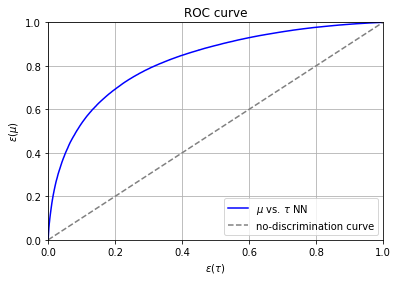

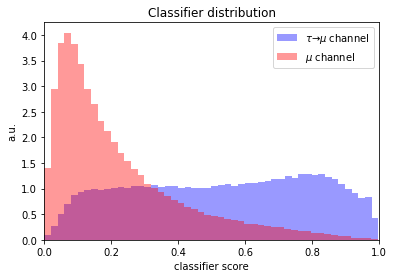

<Figure size 432x288 with 0 Axes>

In [10]:
##########################
### ROC & SCORE CURVES ###
##########################


# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
plt.savefig('graphs/nn_roc.pdf')
plt.show()
#plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.tau_pt>=0]
test_mu  = test[test.tau_pt <0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
plt.legend(loc='best')
plt.savefig('graphs/nn_score.pdf')
plt.show()
plt.clf()

In [11]:
# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

AUC = 0.8225397775416481
Gini index = 0.6450795550832962
